In [2]:
from curses.ascii import isdigit

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import seaborn as sns

In [3]:
domains = pd.read_csv('train.csv', index_col=0)
domains.head()

,category,clicks,likes,buys,4xx_errors,5xx_errors,complaints_count,average_dwelltime,source_attractiveness,date_of_registration
6622,ecom,6488536.0,NaN,0,82221,0,0,18.450527,0.461750,2020-04-21 16:04:41.817367072
2047,information_source,874840.0,21100.0,0,12872,0,0,10.721619,-0.022317,2024-07-19 23:50:07.268931816
1118,information_source,571210.0,94707.0,0,0,7420,0,1.922243,0.046396,2024-07-13 16:35:54.794883135
4992,news,89534.0,924.0,0,834,0,0,2.149243,-0.093360,2024-09-10 21:29:14.006315095
9970,information_source,1043953.0,289288.0,0,58375,20260,3948,3.764965,0.027303,2024-05-26 11:07:15.950527838


In [4]:
domains.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 6622 to 9289
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   category               8000 non-null   object 
 1   clicks                 7727 non-null   float64
 2   likes                  7624 non-null   float64
 3   buys                   8000 non-null   int64  
 4   4xx_errors             8000 non-null   int64  
 5   5xx_errors             8000 non-null   int64  
 6   complaints_count       7527 non-null   object 
 7   average_dwelltime      8000 non-null   float64
 8   source_attractiveness  8000 non-null   float64
 9   date_of_registration   8000 non-null   object 
dtypes: float64(4), int64(3), object(3)
memory usage: 687.5+ KB


In [5]:
domains['category'].value_counts()

category
information_source    3934
ecom                  2452
news                   816
social                 415
porn                   383
Name: count, dtype: int64

In [6]:
one_hot_category = pd.get_dummies(domains['category'], dtype=int)
domains = domains.join(one_hot_category).drop('category', axis=1)
domains.head()

,clicks,likes,buys,4xx_errors,5xx_errors,complaints_count,average_dwelltime,source_attractiveness,date_of_registration,ecom,information_source,news,porn,social
6622,6488536.0,NaN,0,82221,0,0,18.450527,0.461750,2020-04-21 16:04:41.817367072,1,0,0,0,0
2047,874840.0,21100.0,0,12872,0,0,10.721619,-0.022317,2024-07-19 23:50:07.268931816,0,1,0,0,0
1118,571210.0,94707.0,0,0,7420,0,1.922243,0.046396,2024-07-13 16:35:54.794883135,0,1,0,0,0
4992,89534.0,924.0,0,834,0,0,2.149243,-0.093360,2024-09-10 21:29:14.006315095,0,0,1,0,0
9970,1043953.0,289288.0,0,58375,20260,3948,3.764965,0.027303,2024-05-26 11:07:15.950527838,0,1,0,0,0


In [7]:
na_values = np.array([x for x in domains['complaints_count'] if type(x) is not str or not x.isdigit()])
unique, counts = np.unique(na_values, return_counts=True)
for x, y in zip(unique, counts):
    print(f'{x}: {y}')

-: 411
nan: 473


In [8]:
domains.loc[domains['complaints_count'] == '-', 'complaints_count'] = float('nan')
domains['complaints_count'] = domains['complaints_count'].astype(float)

domains['date_of_registration'] = pd.to_datetime(domains['date_of_registration'])

domains.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 6622 to 9289
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   clicks                 7727 non-null   float64       
 1   likes                  7624 non-null   float64       
 2   buys                   8000 non-null   int64         
 3   4xx_errors             8000 non-null   int64         
 4   5xx_errors             8000 non-null   int64         
 5   complaints_count       7116 non-null   float64       
 6   average_dwelltime      8000 non-null   float64       
 7   source_attractiveness  8000 non-null   float64       
 8   date_of_registration   8000 non-null   datetime64[ns]
 9   ecom                   8000 non-null   int64         
 10  information_source     8000 non-null   int64         
 11  news                   8000 non-null   int64         
 12  porn                   8000 non-null   int64         
 13  socia

In [9]:
domains.describe()

,clicks,likes,buys,4xx_errors,5xx_errors,complaints_count,average_dwelltime,source_attractiveness,date_of_registration,ecom,information_source,news,porn,social
count,7.727000e+03,7.624000e+03,8.000000e+03,8.000000e+03,8.000000e+03,7116.000000,8000.000000,8000.000000,8000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,2.749785e+06,5.985027e+05,5.810509e+05,8.204958e+04,2.769224e+04,6418.338252,6.979549,0.191997,2022-09-28 22:35:10.708688128,0.306500,0.491750,0.102000,0.047875,0.051875
min,5.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,-1.000000,-0.681718,2007-01-12 16:44:19.386643264,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.599210e+05,0.000000e+00,0.000000e+00,2.943000e+03,0.000000e+00,144.500000,1.503928,0.038220,2022-01-02 17:34:09.077405952,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.097221e+06,3.399550e+04,0.000000e+00,2.671750e+04,0.000000e+00,1393.000000,4.022802,0.154256,2023-05-14 16:10:44.673421312,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.915358e+06,2.860638e+05,0.000000e+00,9.500225e+04,2.016375e+04,5099.750000,8.899400,0.282510,2024-02-29 10:31:30.423716352,1.000000,1.000000,0.000000,0.000000,0.000000
max,6.203206e+07,5.582181e+07,4.277391e+07,2.904996e+06,1.865588e+06,402119.000000,211.218066,1.355736,2024-09-29 19:18:45.569391241,1.000000,1.000000,1.000000,1.000000,1.000000
std,4.699120e+06,1.978345e+06,2.262221e+06,1.555219e+05,7.946935e+04,16082.069321,10.004924,0.227873,NaN,0.461069,0.499963,0.302667,0.213515,0.221788


<Figure size 1000x1000 with 0 Axes>

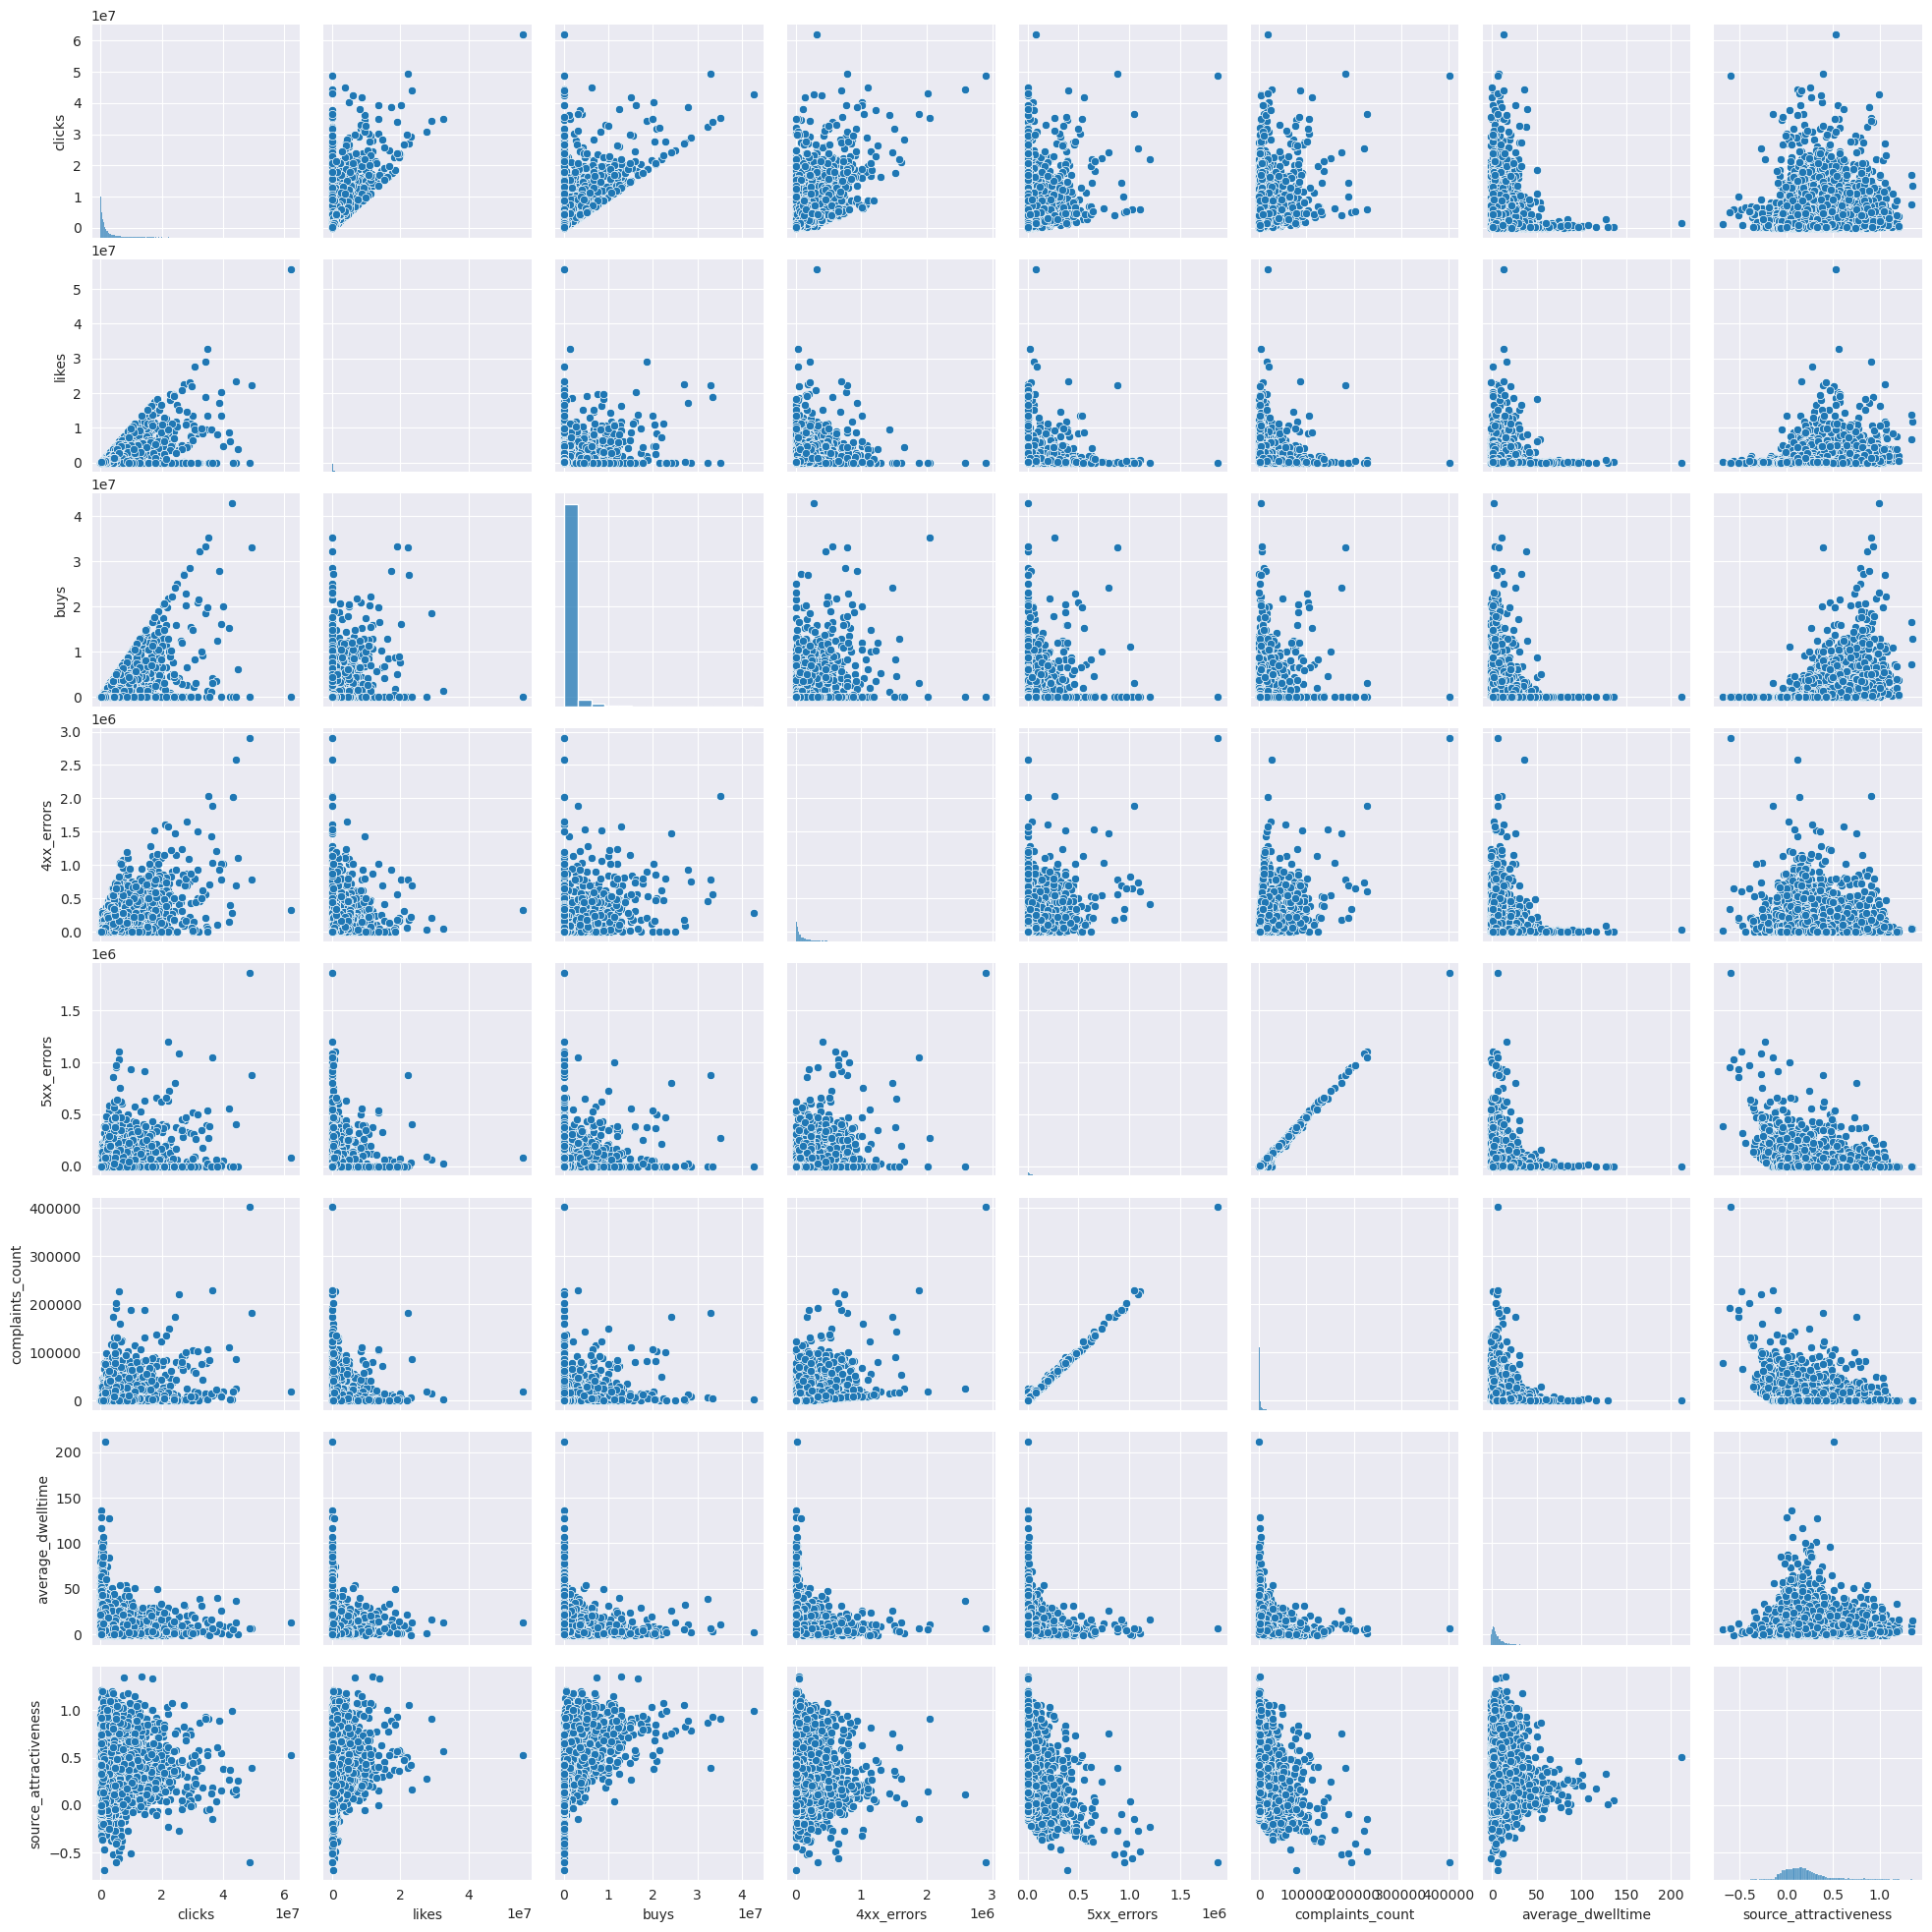

In [10]:
plt.figure(figsize=(10, 10))
categories = ['ecom', 'information_source', 'news', 'porn', 'social']

sns.pairplot(domains.drop(columns=categories), diag_kind='hist')
plt.show()

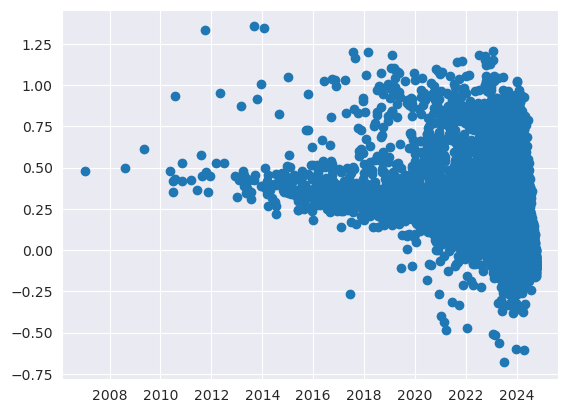

In [13]:
plt.scatter(domains['date_of_registration'], domains['source_attractiveness'])

plt.show()

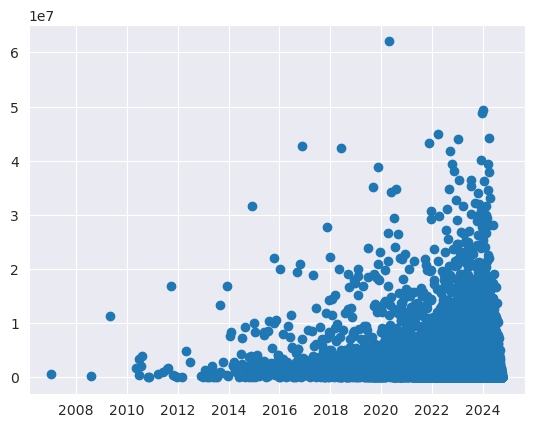

In [14]:
plt.scatter(domains['date_of_registration'], domains['clicks'])
plt.show()


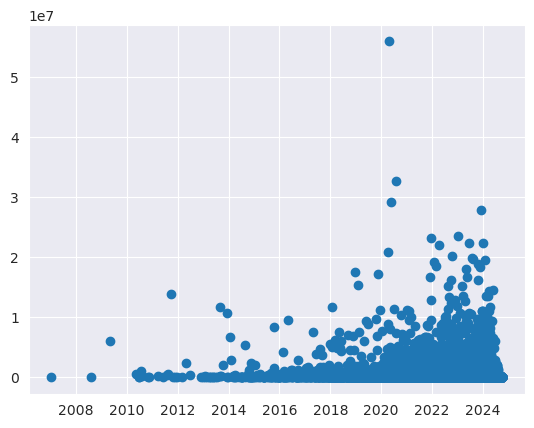

In [15]:
plt.scatter(domains['date_of_registration'], domains['likes'])
plt.show()


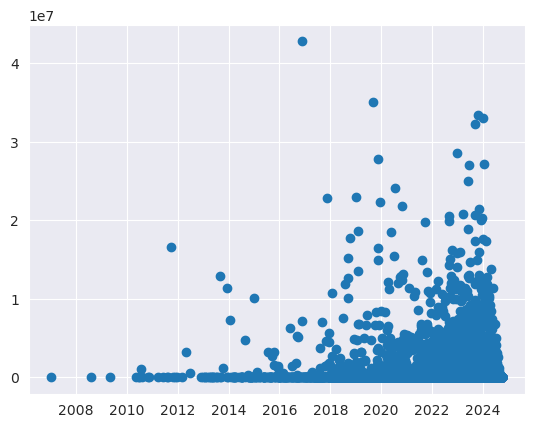

In [16]:
plt.scatter(domains['date_of_registration'], domains['buys'])
plt.show()


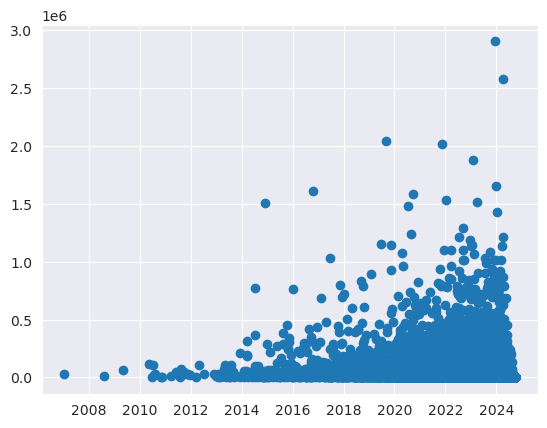

In [17]:
plt.scatter(domains['date_of_registration'], domains['4xx_errors'])
plt.show()


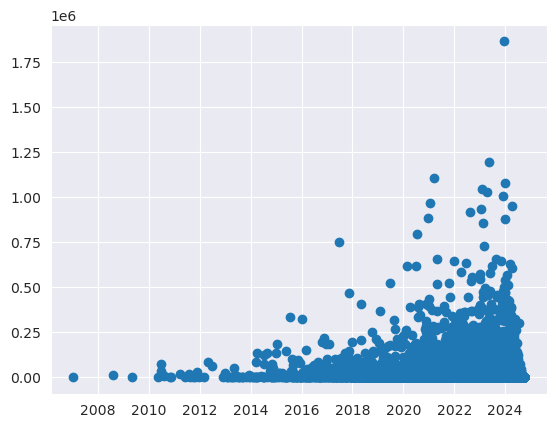

In [18]:
plt.scatter(domains['date_of_registration'], domains['5xx_errors'])
plt.show()


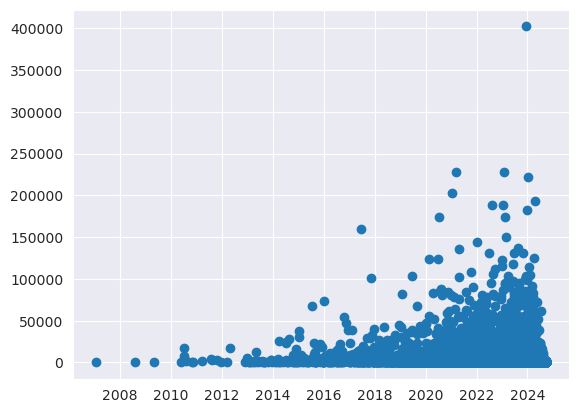

In [19]:
plt.scatter(domains['date_of_registration'], domains['complaints_count'])
plt.show()


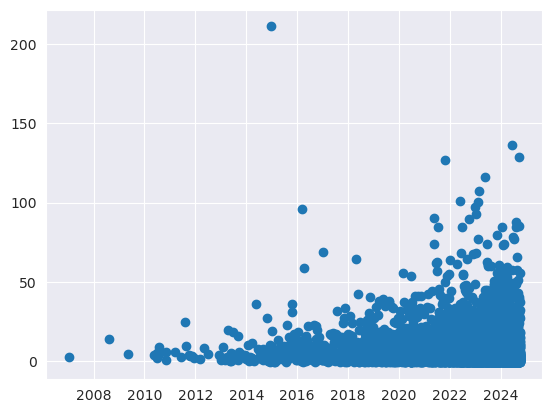

In [20]:
plt.scatter(domains['date_of_registration'], domains['average_dwelltime'])
plt.show()
